In [18]:
pip install tensorflow-text tf-models-official

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 1.8 MB 2.1 MB/s            
     |████████████████████████████████| 39.8 MB 1.6 MB/s            
     |████████████████████████████████| 1.9 MB 1.0 MB/s            
     |████████████████████████████████| 352 kB 1.4 MB/s            
     |████████████████████████████████| 43 kB 647 kB/s            
     |████████████████████████████████| 98 kB 1.3 MB/s            
     |████████████████████████████████| 7.8 MB 1.4 MB/s            
     |████████████████████████████████| 61 kB 576 kB/s             
     |████████████████████████████████| 47.6 MB 518 kB/s            
     |████████████████████████████████| 99 kB 711 kB/s            
     |████████████████████████████████| 1.2 MB 737 kB/s            
     |████████████████████████████████| 10.3 MB 1.2 MB/s            
     |████████████████████████████████| 1.1 MB 405 kB/s            
     |████████████████████████████████

In [17]:
import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization

import matplotlib.pyplot as plt

tf.get_logger().setLevel('ERROR')

ModuleNotFoundError: No module named 'official'

In [ ]:
dataset_dir = os.path.join(os.path.dirname('data'))

train_dir = os.path.join(dataset_dir, 'train')

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 128
seed = 42

raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'data/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed)

class_names = raw_train_ds.class_names
train_ds = raw_train_ds.cache().prefetch(buffer_size=AUTOTUNE)

val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'data/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)

val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

test_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'data/test',
    batch_size=batch_size)

test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 10642 files belonging to 6 classes.
Using 8514 files for training.
Found 10642 files belonging to 6 classes.
Using 2128 files for validation.
Found 1309 files belonging to 6 classes.


In [6]:
for text_batch, label_batch in train_ds.take(1):
    for i in range(3):
        print(f'Review: {text_batch.numpy()[i]}')
        label = label_batch.numpy()[i]
        print(f'Label : {label}({class_names[label]})')

Review: b'i do these days that makes me feel a little uncertain about the future the pressures that pierce me deep the feeling of being completely isolated from the world i used to glory in and all the thrills that go with it\r\n'
Label : 1(Fear)
Review: b'i feel badly enough about myself and everything thats going on and some of these people that are supposed to be helping me arent particularly sympathetic\r\n'
Label : 3(Love)
Review: b'i go to bed feeling very distraught otherwise\r\n'
Label : 1(Fear)


In [9]:
bert_model_name = 'small_bert/bert_en_uncased_L-4_H-512_A-8' 

map_name_to_handle = {
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1'
}

map_model_to_preprocess = {
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


In [11]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

In [14]:
text_test = ['i am very happy!']
text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

Keys : ['input_type_ids', 'input_mask', 'input_word_ids']
Shape      : (1, 128)
Word Ids   : [ 101 1045 2572 2200 3407  999  102    0    0    0    0    0]
Input Mask : [1 1 1 1 1 1 1 0 0 0 0 0]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


In [15]:
bert_model = hub.KerasLayer(tfhub_handle_encoder)

In [16]:
bert_results = bert_model(text_preprocessed)

print(f'Loaded BERT: {tfhub_handle_encoder}')
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')

Loaded BERT: https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Pooled Outputs Shape:(1, 512)
Pooled Outputs Values:[ 0.24941826  0.9915464  -0.4749972   0.27724522  0.5778725   0.90980035
  0.9993191  -0.97961843 -0.397511   -0.9999336   0.2814727  -0.9883225 ]
Sequence Outputs Shape:(1, 128, 512)
Sequence Outputs Values:[[ 0.865002   -0.43479046  0.23863408 ... -0.66000634  0.72703046
  -0.03641245]
 [ 0.6866704   0.6730187   0.23620787 ... -1.012538    0.19366297
  -0.39518255]
 [ 0.45706603  0.609636   -0.6904862  ... -1.044126   -0.94939023
  -0.49390918]
 ...
 [ 0.30389774 -0.6682589  -0.73892057 ... -0.43571913  0.91625154
   0.19610333]
 [ 0.68979114 -0.37165576 -0.271005   ... -0.11636052  0.884899
  -0.04511157]
 [ 0.48176616 -0.96007544 -0.2895785  ... -0.23374471  1.0972216
   0.01789726]]


In [17]:
def build_classifier_model():
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output']
    net = tf.keras.layers.Dropout(0.1)(net)
    net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
    return tf.keras.Model(text_input, net)

In [18]:
classifier_model = build_classifier_model()
bert_raw_result = classifier_model(tf.constant(text_test))
print(tf.sigmoid(bert_raw_result))

tf.Tensor([[0.2853806]], shape=(1, 1), dtype=float32)


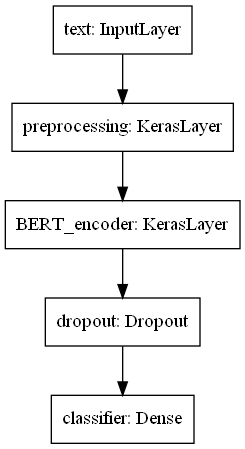

In [19]:
tf.keras.utils.plot_model(classifier_model)

In [20]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

In [21]:
epochs = 5
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [22]:
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [24]:
print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model.fit(x=train_ds,
                               validation_data=val_ds,
                               epochs=epochs)

Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Epoch 1/5
267/267 [==============================] - 1796s 7s/step - loss: -29.8900 - binary_accuracy: 0.1866 - val_loss: -49.3229 - val_binary_accuracy: 0.1706
Epoch 2/5
267/267 [==============================] - 8519s 32s/step - loss: -51.4421 - binary_accuracy: 0.1850 - val_loss: -56.1708 - val_binary_accuracy: 0.1706
Epoch 3/5
267/267 [==============================] - 1624s 6s/step - loss: -56.4607 - binary_accuracy: 0.1850 - val_loss: -59.9406 - val_binary_accuracy: 0.1706
Epoch 4/5
267/267 [==============================] - 1675s 6s/step - loss: -59.3593 - binary_accuracy: 0.1850 - val_loss: -62.0740 - val_binary_accuracy: 0.1706
Epoch 5/5
267/267 [==============================] - 1626s 6s/step - loss: -60.7046 - binary_accuracy: 0.1850 - val_loss: -62.7703 - val_binary_accuracy: 0.1706


In [25]:
loss, accuracy = classifier_model.evaluate(test_ds)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

41/41 [==============================] - 103s 2s/step - loss: -61.2084 - binary_accuracy: 0.1719
Loss: -61.208370208740234
Accuracy: 0.17188693583011627


dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


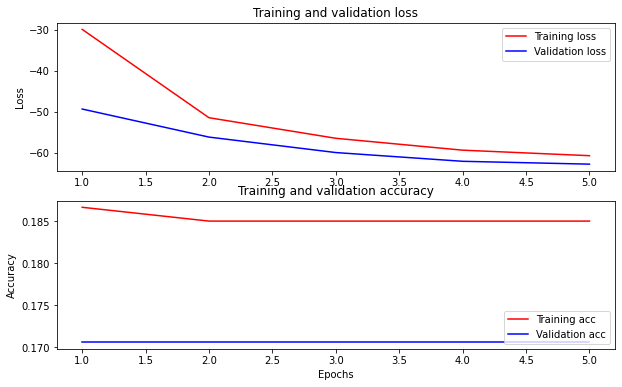

In [26]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [27]:
dataset_name = 'data'
saved_model_path = './{}_bert'.format(dataset_name.replace('/', '_'))

classifier_model.save(saved_model_path, include_optimizer=False)

In [28]:
reloaded_model = tf.saved_model.load(saved_model_path)

In [29]:
def print_my_examples(inputs, results):
  result_for_printing = \
    [f'input: {inputs[i]:<30} : score: {results[i][0]:.6f}'
                         for i in range(len(inputs))]
  print(*result_for_printing, sep='\n')
  print()


examples = [
    'i am happy!',  # this is the same sentence tried earlier
    'i am afraid!',
    'i want you!',
    'i am upset!',
    'i am shocked!'
]

reloaded_results = tf.sigmoid(reloaded_model(tf.constant(examples)))
original_results = tf.sigmoid(classifier_model(tf.constant(examples)))

print('Results from the saved model:')
print_my_examples(examples, reloaded_results)
print('Results from the model in memory:')
print_my_examples(examples, original_results)

Results from the saved model:
input: i am happy!                    : score: 1.000000
input: i am afraid!                   : score: 1.000000
input: i want you!                    : score: 1.000000
input: i am upset!                    : score: 1.000000
input: i am shocked!                  : score: 1.000000

Results from the model in memory:
input: i am happy!                    : score: 1.000000
input: i am afraid!                   : score: 1.000000
input: i want you!                    : score: 1.000000
input: i am upset!                    : score: 1.000000
input: i am shocked!                  : score: 1.000000



In [30]:
serving_results = reloaded_model \
            .signatures['serving_default'](tf.constant(examples))

serving_results = tf.sigmoid(serving_results['classifier'])

print_my_examples(examples, serving_results)

input: i am happy!                    : score: 1.000000
input: i am afraid!                   : score: 1.000000
input: i want you!                    : score: 1.000000
input: i am upset!                    : score: 1.000000
input: i am shocked!                  : score: 1.000000

